## Reproductible fitting 

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from jmstate import MultiStateJointModel
from jmstate.utils import *
from jmstate.base_hazard import weibull

from uniformbands import get_bands

torch.manual_seed(0)

In [2]:
def sigmoid(t, x, psi):
    a = psi[:, [0]]
    b = psi[:, [1]]
    c = psi[:, [2]]

    res = a * torch.sigmoid(b * (t - c))
    return res[:, :, None] 


def f(gamma, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [3]:
##############################################

lmda = 6
k = 2

gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.tensor([1.0, 0.1, 1.0])
Q_repr = -0.5 * torch.log(Q)
R = torch.tensor([1.1])
R_repr = -0.5 * torch.log(R)

alphas = {
    (0, 1): torch.tensor([1.7]),
}
betas = {
    (0, 1): torch.tensor([-1.34, 2.5, 3.2]),
}

real_params = ModelParams(gamma, (Q_repr, "diag"), (R_repr, "ball"), alphas, betas)

In [4]:
weibull_fn = weibull(k, lmda)

surv = {
    (0, 1): (weibull_fn, sigmoid),
}

In [5]:
model_design = ModelDesign(f, sigmoid, surv)

In [6]:
real_model = MultiStateJointModel(model_design, real_params, n_quad=64)

n, p = 500, 3

# Generate training set
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)
b = torch.randn(n, real_params.gamma.shape[0]) * torch.sqrt(Q)
psi = f(real_params.gamma, b)

In [7]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)

In [8]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 1
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

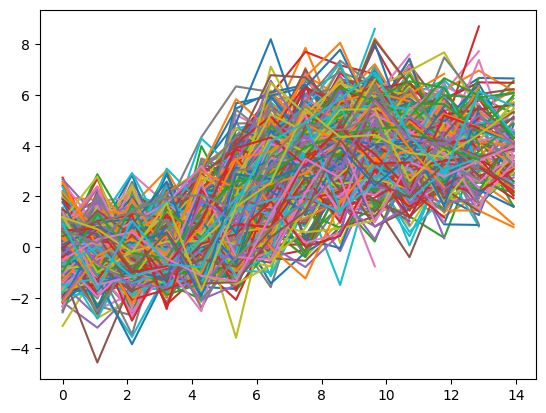

In [9]:
y = model_design.h(t, x, psi)
y += torch.randn_like(y) * torch.sqrt(R)
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan
plt.plot(t, y.squeeze(-1).T)
plt.show()

In [10]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(Q_repr), "diag"),
    (torch.zeros_like(R_repr), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

In [11]:
data = ModelData(x, t, y, trajectories, c)

In [12]:
buckets = build_buckets(trajectories)
print([(key, buckets[key][0].numel()) for key in buckets.keys()])

[((0, 1), 479)]


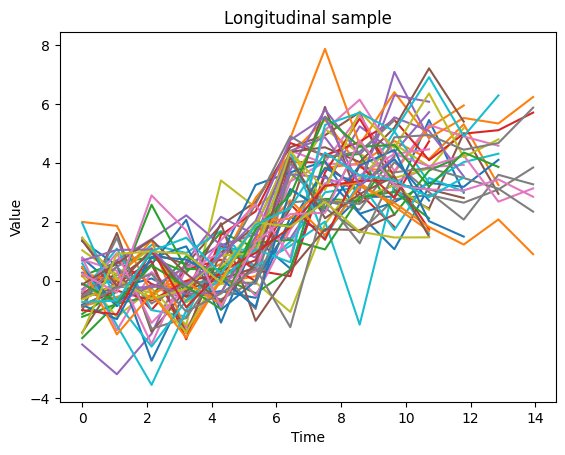

In [13]:
plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.xlabel("Time")
plt.ylabel("Value")
plt.savefig("Figures/sample_plot.png")
plt.show()

In [14]:
history = []

callback = lambda: history.append([p.detach().clone() for p in model.params_.as_list])

model = MultiStateJointModel(model_design, init_params)
model.fit(data, callback=callback, n_iter=3000, batch_size=4)

Fitting joint model: 100%|██████████| 3000/3000 [01:13<00:00, 40.99it/s]


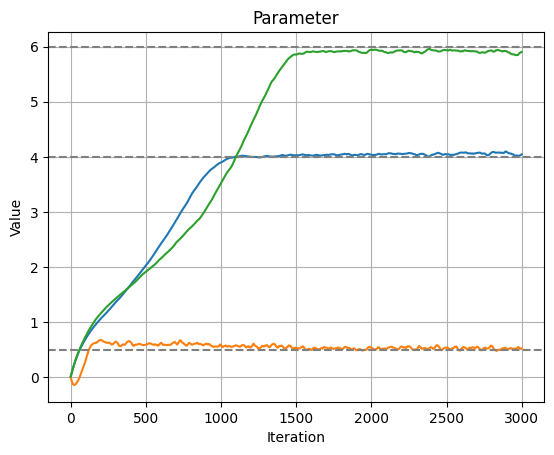

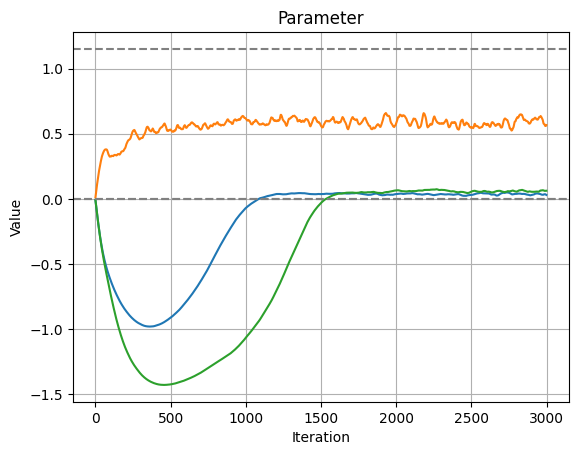

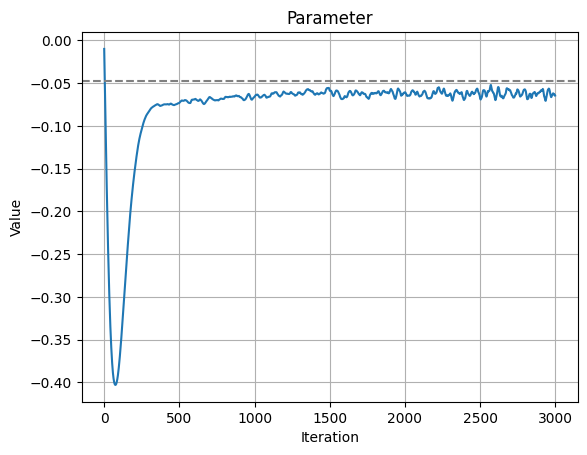

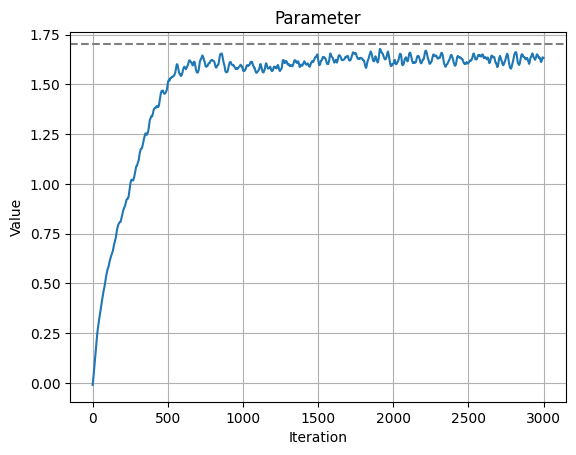

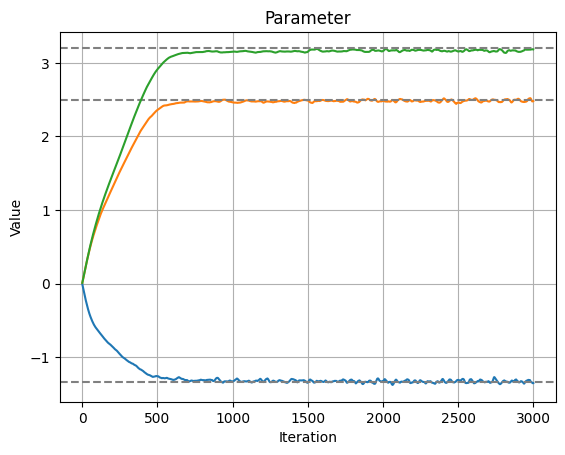

In [15]:
real_params_list = real_params.as_list

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])
        plt.axhline(y=float(real_params_list[i][j]), linestyle="--", color="gray")

    plt.title(f"Parameter")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [16]:
print("Estimation")
print(model.params_)

Estimation
ModelParams(gamma=tensor([4.0441, 0.5174, 5.9043], requires_grad=True), Q_repr=(tensor([0.0301, 0.5662, 0.0621], requires_grad=True), 'diag'), R_repr=(tensor([-0.0645], requires_grad=True), 'ball'), alphas={(0, 1): tensor([1.6324], requires_grad=True)}, betas={(0, 1): tensor([-1.3552,  2.4791,  3.1841], requires_grad=True)})


In [17]:
# Generate test individual

torch.manual_seed(1234)

n_test = 1

# Generate training set
c_test = torch.rand(n_test) * 5 + 10
x_test = torch.randn(n_test, p)
b_test = torch.randn(n_test, real_params.gamma.shape[0]) * torch.sqrt(Q)
psi_test = f(real_params.gamma, b_test)

trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

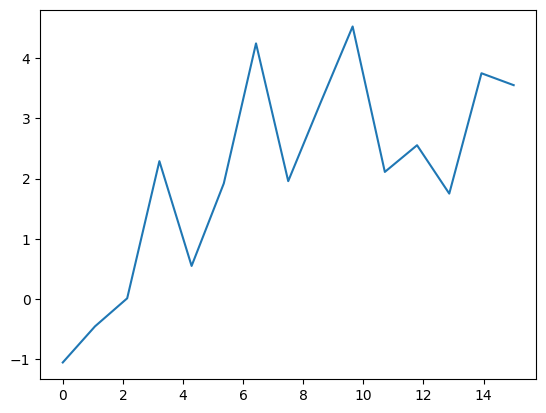

In [18]:
y_test = model_design.h(t, x_test, psi_test)
y_test += torch.randn_like(y_test) * torch.sqrt(R)
plt.plot(t, y_test.squeeze(-1).T)
plt.show()

In [27]:
log_probs = []

prediction_times = torch.linspace(2.0, 6.0, 5)

for time in prediction_times:
    c_test = torch.full((n_test,), time)
    
    sample_test_data = SampleData(
        x_test,
        trajectories_init_test,
        psi_test,
        c_test,
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs.append(real_model.compute_surv_log_probs(sample_test_data, u))

In [30]:

log_probs_pred = []

for time in prediction_times:
    c_test = torch.full((n_test,), time)

    pred_test_data = ModelData(
        x_test,
        t[t <= time],
        y_test[:, t <= time, :],
        trajectories_init_test,
        c_test
    )

    u = c_test.view(-1, 1) + torch.linspace(0, 4, 50).view(1, -1)

    log_probs_pred.append(model.predict_surv_log_probs(pred_test_data, u, n_iter_b=1000))

Predicting survival probabilities: 100%|██████████| 1000/1000 [00:08<00:00, 118.39it/s]


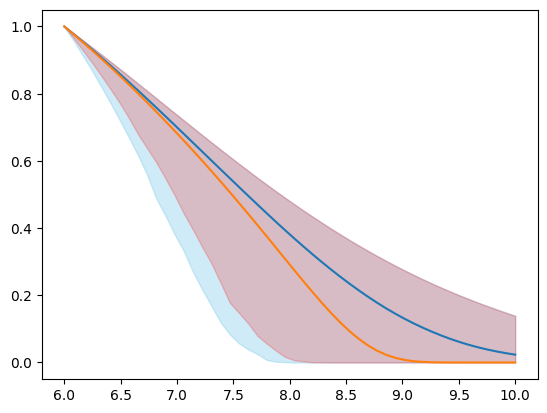

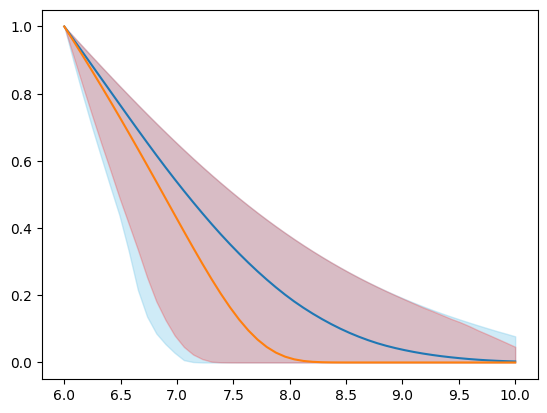

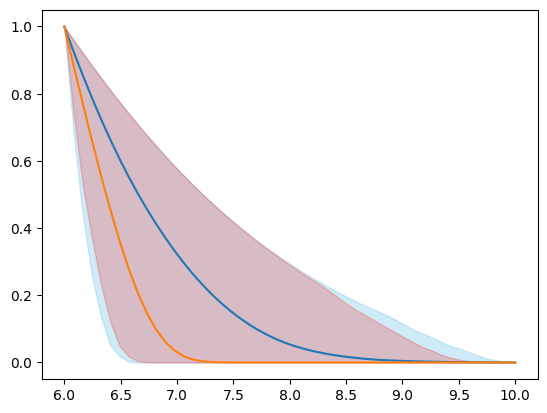

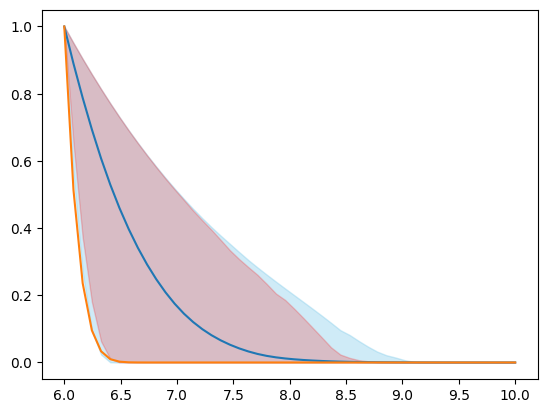

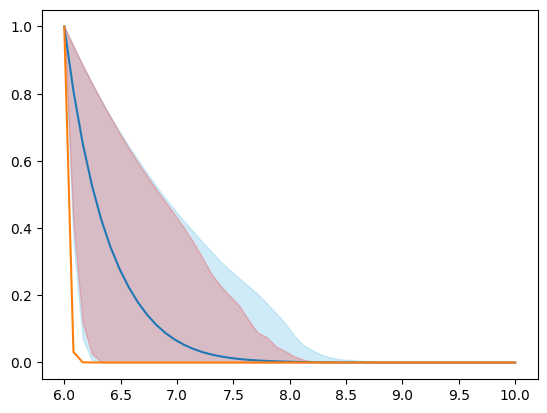

In [31]:
for lp, lpp in zip(log_probs, log_probs_pred):
    probs_pred = torch.vstack([torch.exp(lpp[i][0].detach()) for i in range(len(lpp))]).numpy()

    bands = get_bands(probs_pred)
    pointwise = np.quantile(probs_pred, [0.025, 0.975], axis=0)

    points = u.numpy()[0] 

    plt.plot(points, probs_pred.mean(axis=0))
    plt.fill_between(points, bands["lower"], bands["upper"], 
                    color='skyblue',                           # couleur “dans le nuage”
                    alpha=0.4)
    plt.fill_between(points, pointwise[0], pointwise[1], 
                    color='red',                           # couleur “dans le nuage”
                    alpha=0.2)
    plt.plot(points, torch.exp(lp[0]).numpy())
    plt.show()